# Overclustering experiments with TMM

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import studenttmixture
import matplotlib.pyplot as plt
import sklearn.mixture
import numpy as np
import tqdm
import itertools
import scipy
import scipy.sparse.csgraph
import jax.random as jrandom

# own code
import src.corc.datasets_refactor as datasets2d
import src.corc.jax_neb as jax_neb

In [33]:
key = jrandom.PRNGKey(0)
datasets = {
    'Clusterlab1': datasets2d.Clusterlab1().sample(key, 100),
    'Clusterlab2': datasets2d.Clusterlab2().sample(key, 200),
    'Clusterlab3': datasets2d.Clusterlab3().sample(key, 200),
    'Clusterlab4': datasets2d.Clusterlab4().sample(key, 200),
    'Clusterlab6': datasets2d.Clusterlab6().sample(key, 250),
    'Clusterlab8': datasets2d.Clusterlab8().sample(key, 300),
    'Clusterlab9': datasets2d.Clusterlab9().sample(key, 300),
    'Clusterlab10': datasets2d.Clusterlab10().sample(key, 300),
    'BowTie': datasets2d.BowTie().sample(key, 256),
    # 'ZigZag': datasets2d.ZigZag().sample(key, 64),
    'UniformCircle': datasets2d.UniformCircle().sample(key, 256),
    'UniformSquare': datasets2d.UniformSquare().sample(key, 256),
}

# missing are: AnisoBlobs, Blobs, Circles, Clusterlab5, Clusterlab7, Moons, ZigZig
# clusterlab5 has different number of points per blob (15,50,50,50)
# clusterlab7 is clusterlab6 plus 10 outliers
# ZigZag is broken
print(f"there are {len(datasets)} datasets")

there are 11 datasets


In [32]:
data_X, data_y = datasets['Clusterlab10']
print(f'current dataset has {len(set(data_y.tolist()))} dimensions')

current dataset has 6 dimensions


In [34]:
overclustering_n = 15 # always use the same number of clusters

In [58]:
# compute tmm
tmm = studenttmixture.EMStudentMixture(n_components=overclustering_n, fixed_df=True, df=1.0, init_type="k++", random_state=42)
tmm.fit(np.array(data_X, dtype=np.float64))

In [62]:
adjacency, _, paths, temps, logprobs = jax_neb.compute_neb_paths(tmm, iterations=500)

100%|██████████| 225/225 [14:54<00:00,  3.98s/it]


In [65]:
thresholds = set(adjacency.flatten())
thresholds

{-9.34257984161377,
 -9.208929061889648,
 -8.90778636932373,
 -8.713793754577637,
 -7.80174446105957,
 -7.45189905166626,
 -6.142277717590332,
 -5.553597450256348,
 -5.443879127502441,
 -5.154192924499512,
 -5.037203788757324,
 -3.5582752227783203,
 -3.3411285877227783,
 -3.088834524154663,
 0.0}

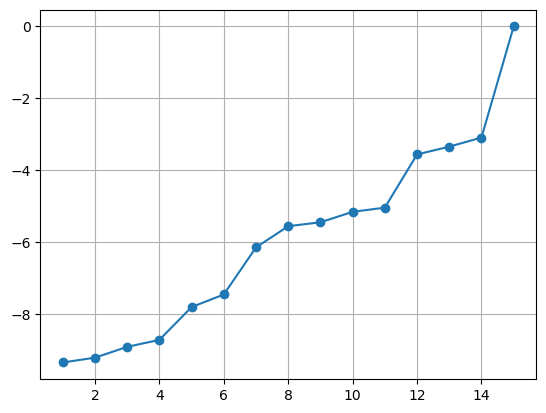

In [88]:

# number of clusters against threshold values
cluster_numbers = list()
for threshold in sorted(list(thresholds)):
    tmp_adj = np.array(adjacency>=threshold,dtype=int)
    n_components, component_labels = scipy.sparse.csgraph.connected_components(tmp_adj, directed=False)
    cluster_numbers.append((threshold, n_components))
    # print(f"With Threshold: {threshold} we get {n_components} components")
    
cluster_numbers = np.array(cluster_numbers)
plt.plot(cluster_numbers[:,1], cluster_numbers[:,0], marker='o')
plt.grid()